## NMEC Baseline Model Predictability:  Data Science Deep Dive

Normalized metered energy consumption (NMEC) methods offer many benefits to energy efficiency utility programs and their participants, but care must be used. NMEC programs rely on baseline models for pre-screening and energy savings calculations following implementation. The results of each of these steps determine program eligibility and the size of a participant’s incentive check. So, it’s vital that methods are used with good judgement and understanding of the statistical principles and key model metrics behind them.

The example presented below demonstrates that current technical guidance should serve only as guidance and not be taken as criteria that determines a site "passing or failing" the NMEC screening process. In this post, I will walk you through an example building dataset where goodness-of-fit thresholds for three key model metrics are met but the baseline model is not sufficient to ensure fair and equitable project outcomes for all stakeholders. Focusing too narrowly on key model metrics, without accounting for the overall context, can lead to poorly performing projects and missed opportunities, especially in the pay-for-performance programs.

### Background of NMEC in Energy Efficiency Programs

Typical (non-NMEC) efficiency programs pay incentives based on estimated or deemed energy saving values, whereas NMEC programs offer pay-for-performance incentives. This creates an undeniable incentive for NMEC program participants to maximize actual energy savings. However, since NMEC baseline models calculate drive both project eligibility and energy savings using, it is imperative that models are as accurate as possible.
To participate in an NMEC program, a building’s energy use must be predictable, within an acceptable degree of certainty. During pre-screening for a site-level NMEC program, a predictability analysis is performed wherein candidate baseline models are screened and vetted to ensure they can adequately characterize a site’s energy use. For buildings with regular operation, like grocery stores or university campus buildings, this can usually be accomplished. However, if models cannot characterize building energy use with enough accuracy, they cannot participate in the program.



The standard procedure in Site-Level NMEC programs involves a predictability analysis stage wherein candidate baseline models are screened and vetted to ensure that they can adequately characterize a site’s energy use. The screening process relies on three key model metrics: 

- CV(RMSE): measure of random error between the model fit and the actual data
- NMBE: measure of the total bias error between the model fit and the actual data
- R2: measure of the amount of variation in the energy use explained by the model

The NMEC Rulebook references the requirements listed in the LBNL Technical Guidance to demonstrate feasibility of NMEC approaches on target buildings. The guidance provides the following three thresholds for model goodness-of-fit:

- CV(RMSE) < 25%
- NMBE between -0.5% and +0.5%
- R2 > 0.7

As with almost all thresholds and magic numbers, these criteria have taken a life of their own and are often referenced and evaluated without context when screening projects for NMEC programs. In this post, I will walk you through an example building dataset where these criteria are met but the baseline model is not sufficient to ensure a fair and equitable outcome for all stakeholders. This issue is of prime importance in pay-for-performance programs where the implementors’ payments depend on these baseline models’ accuracy to characterize the building energy use.  


In [1]:
## Load in required packages

import_package = function(package_name){ ## function to suppress messages and warnings during package load
    suppressWarnings(suppressMessages(require(package_name, character.only = TRUE)))
}

import_package("nmecr")
import_package("ggplot2")

## Predictability Analysis

A predictability analysis usually begins by charting the energy use against time and temperature to visualize energy use patterns and identify major non-routine events that would make the building clearly ineligible for an NMEC program.


Here we have energy use data from a commercial facility in southern California:


In [2]:
eload_data <- readRDS("Data/Processed Energy Consumption - multiyear.rds")
temp_data <- readRDS("Data/Processed Temperature - multiyear.rds")

In [3]:
# Align energy and temperature data at daily intervals

energy_temp_df <- nmecr::create_dataframe(eload_data, temp_data, start_date = "2020-03-31",
                                          end_date = "2021-04-01", 
                                          convert_to_data_interval = "Daily")

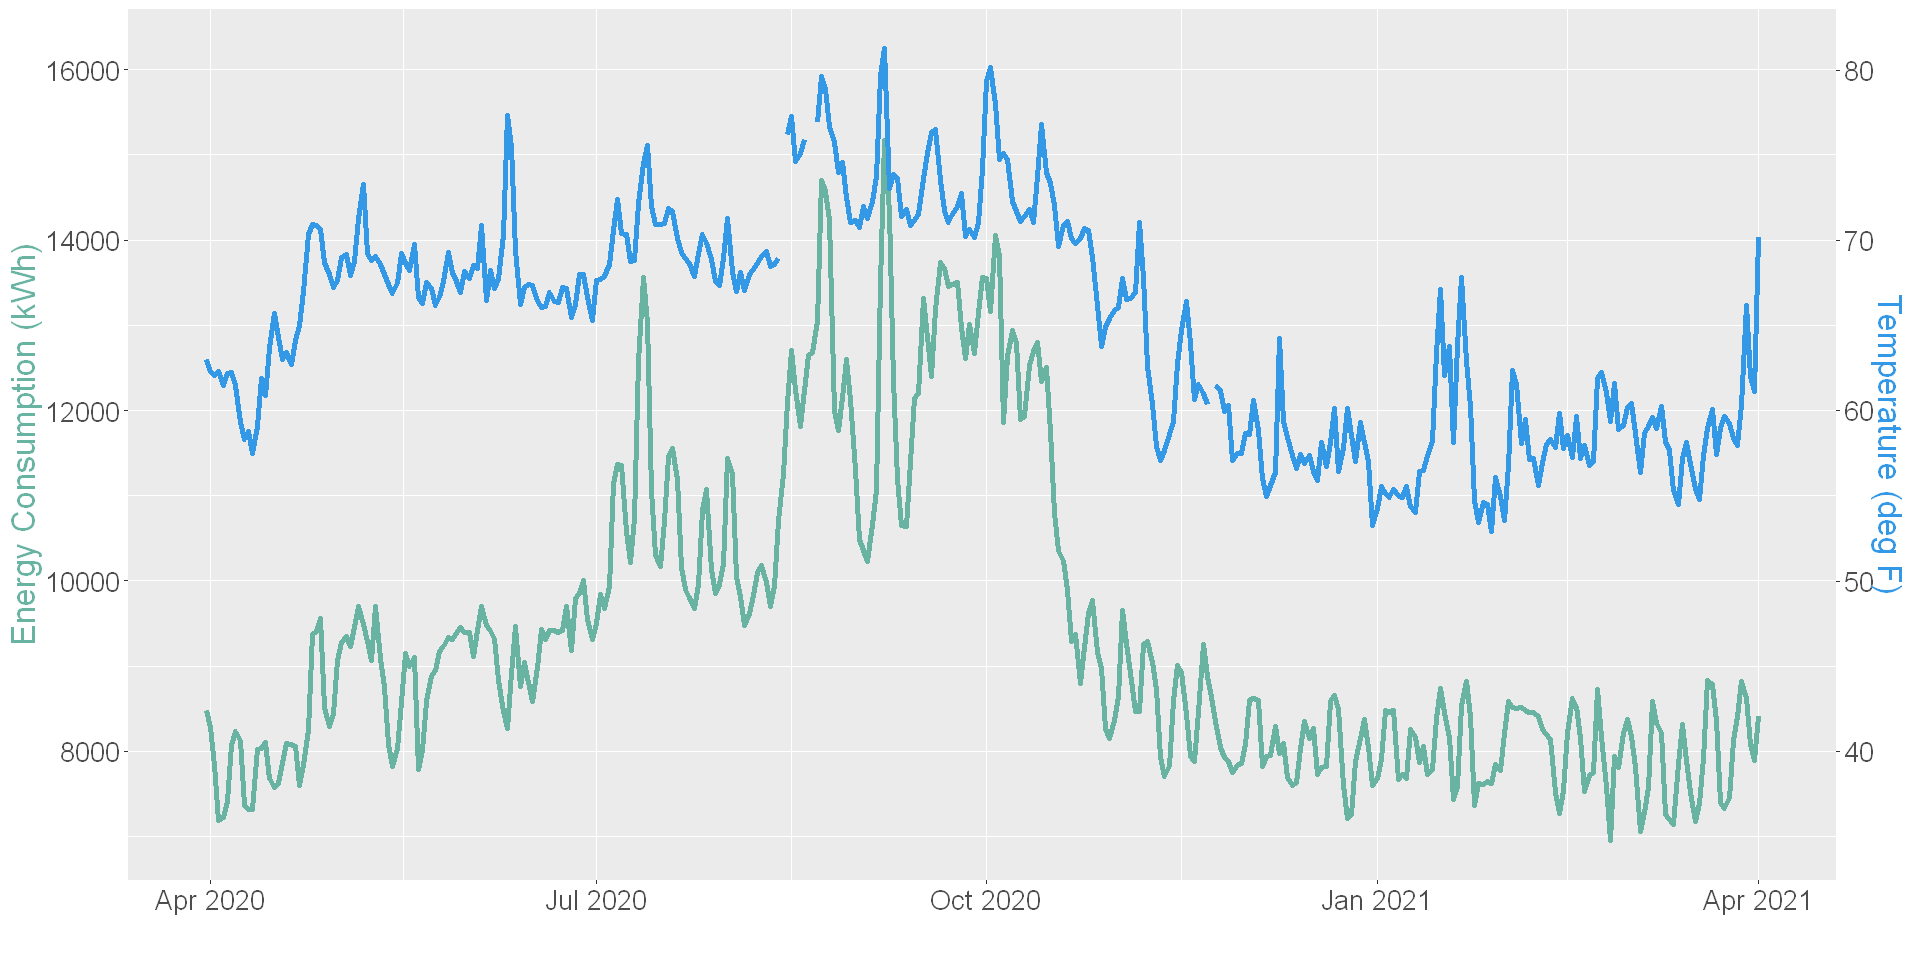

In [4]:
# Plot energy use against time

options(repr.plot.width=16, repr.plot.height=8)
   
temperatureColor <- "#69b3a2"
priceColor <- rgb(0.2, 0.6, 0.9, 1)
    
energy_temp_df %>%
    ggplot2::ggplot(aes(x = time)) +
    geom_line(aes(y=eload), size=1.5, color=temperatureColor) + 
    geom_line( aes(y=temp*200), size=1.5, color=priceColor) +
    scale_y_continuous(
    name = "Energy Consumption (kWh)",    
    sec.axis = sec_axis(~.*1/200, name="Temperature (deg F)")) +
    theme(
    axis.title.y = element_text(color = temperatureColor, size=20),
    axis.title.y.right = element_text(color = priceColor, size=20),
    text = element_text(size = 20)) +
    xlab("")     




The temperature data is plotted in blue on the right-axis, and the energy use data is plotted in green on the left-axis. The two datastreams are plotted as a scatterplot below:

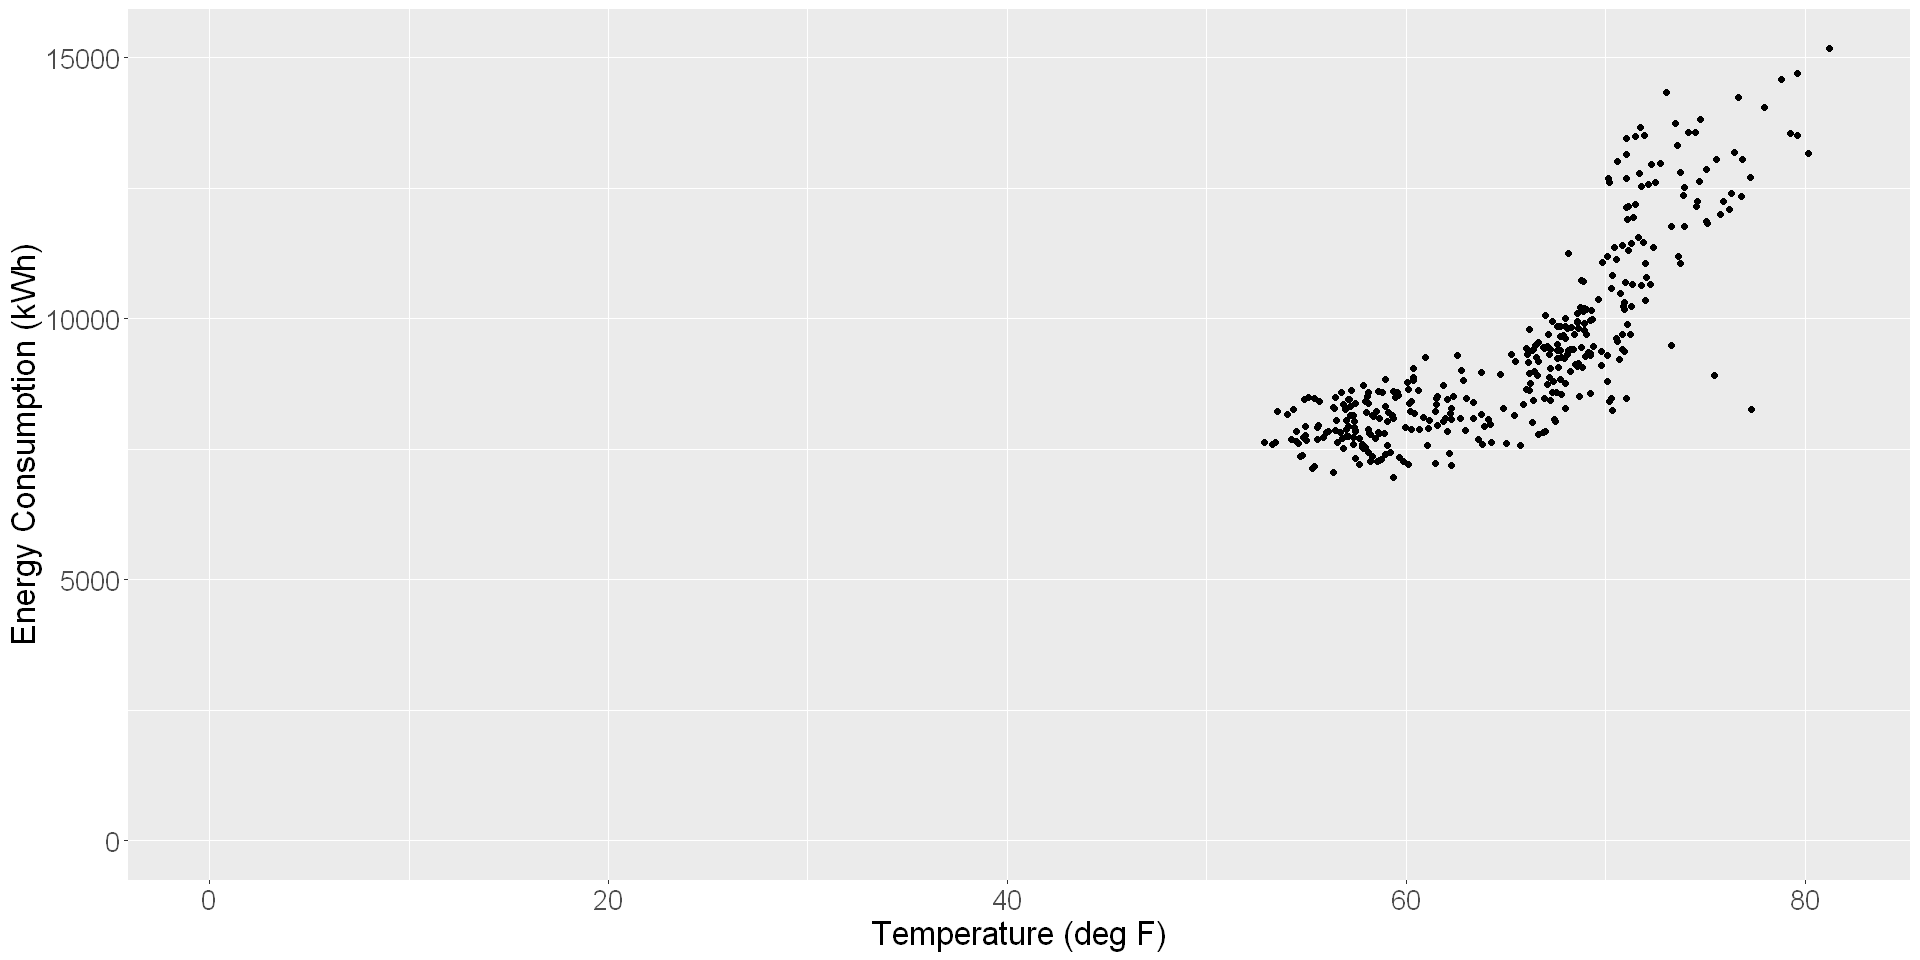

In [5]:
# Plot energy use against temperature
options(repr.plot.width=16, repr.plot.height=8)

energy_temp_df[complete.cases(energy_temp_df), ] %>%
    ggplot2::ggplot(aes(x = temp, y = eload)) +
    geom_point() +
    scale_x_continuous(limits = c(0, NA)) +
    scale_y_continuous(limits = c(0, NA)) +
    theme(text = element_text(size = 20)) +
    labs(x = "Temperature (deg F)", y = "Energy Consumption (kWh)")

Here is a zoomed-in version of the scatterplot:

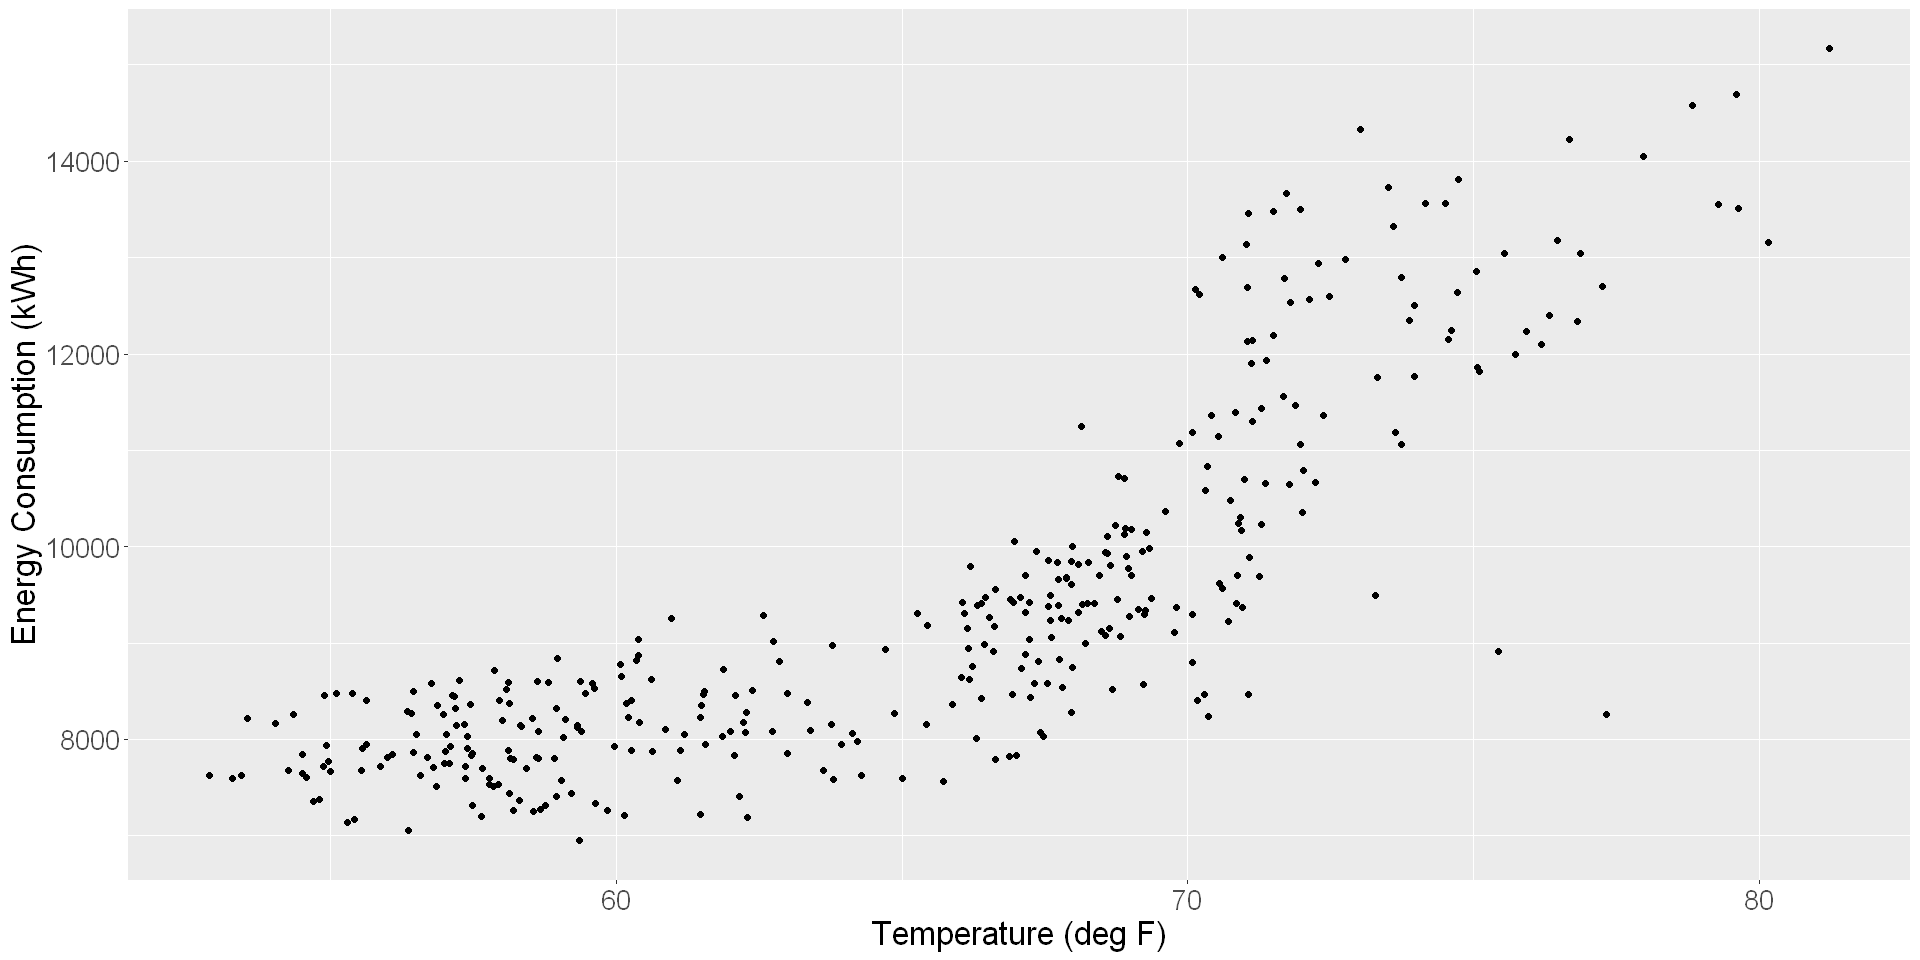

In [6]:
# Plot energy use against temperature - zoomed in

options(repr.plot.width=16, repr.plot.height=8)

energy_temp_df[complete.cases(energy_temp_df), ] %>%
    ggplot2::ggplot(aes(x = temp, y = eload)) +
    geom_point() +
    theme(text = element_text(size = 20)) +
    labs(x = "Temperature (deg F)", y = "Energy Consumption (kWh)")

Given the shape of the scatter plot, a four-parameter model seems appropriate. However, as seen in the time-series chart, the energy use is also dependent on the time of use: weekday vs weekend. 

In the next section, the time-of-week & temperature and the four parameter algorithms are assessed for this data.

## Candidate Model Screening

In [7]:
# create the two models and the dataframe for plotting

four_parameter_model <- nmecr::model_with_CP(training_data = energy_temp_df,
                                               model_input_options = nmecr::assign_model_inputs(regression_type = "4P"))

TOWT_model <- nmecr::model_with_TOWT(training_data = energy_temp_df, 
                                     model_input_options = nmecr::assign_model_inputs(regression_type = "TOWT"))

actual_modeled_df <- four_parameter_model$training_data %>%
    select(-c("model_fit")) %>%
    mutate('4P_fit' = four_parameter_model$training_data$model_fit) %>%
    mutate('TOWT_fit' = TOWT_model$training_data$model_fit)

baseline_scatter_df <- tidyr::pivot_longer(actual_modeled_df,
                                           cols = c("eload", "4P_fit", "TOWT_fit"))

In [8]:
generate_scatter_plot <- function(data) {   # to generate scatter plot 
    data %>%
    ggplot2::ggplot(aes(x = temp, y = value, color = name)) +
    geom_point() +
    scale_x_continuous(limits = c(0, NA)) +
    scale_y_continuous(limits = c(0, NA)) +
    theme(text = element_text(size = 20), legend.title = element_blank()) +
    labs(x = "Temperature (deg F)", y = "Energy Consumption (kWh)")    
}

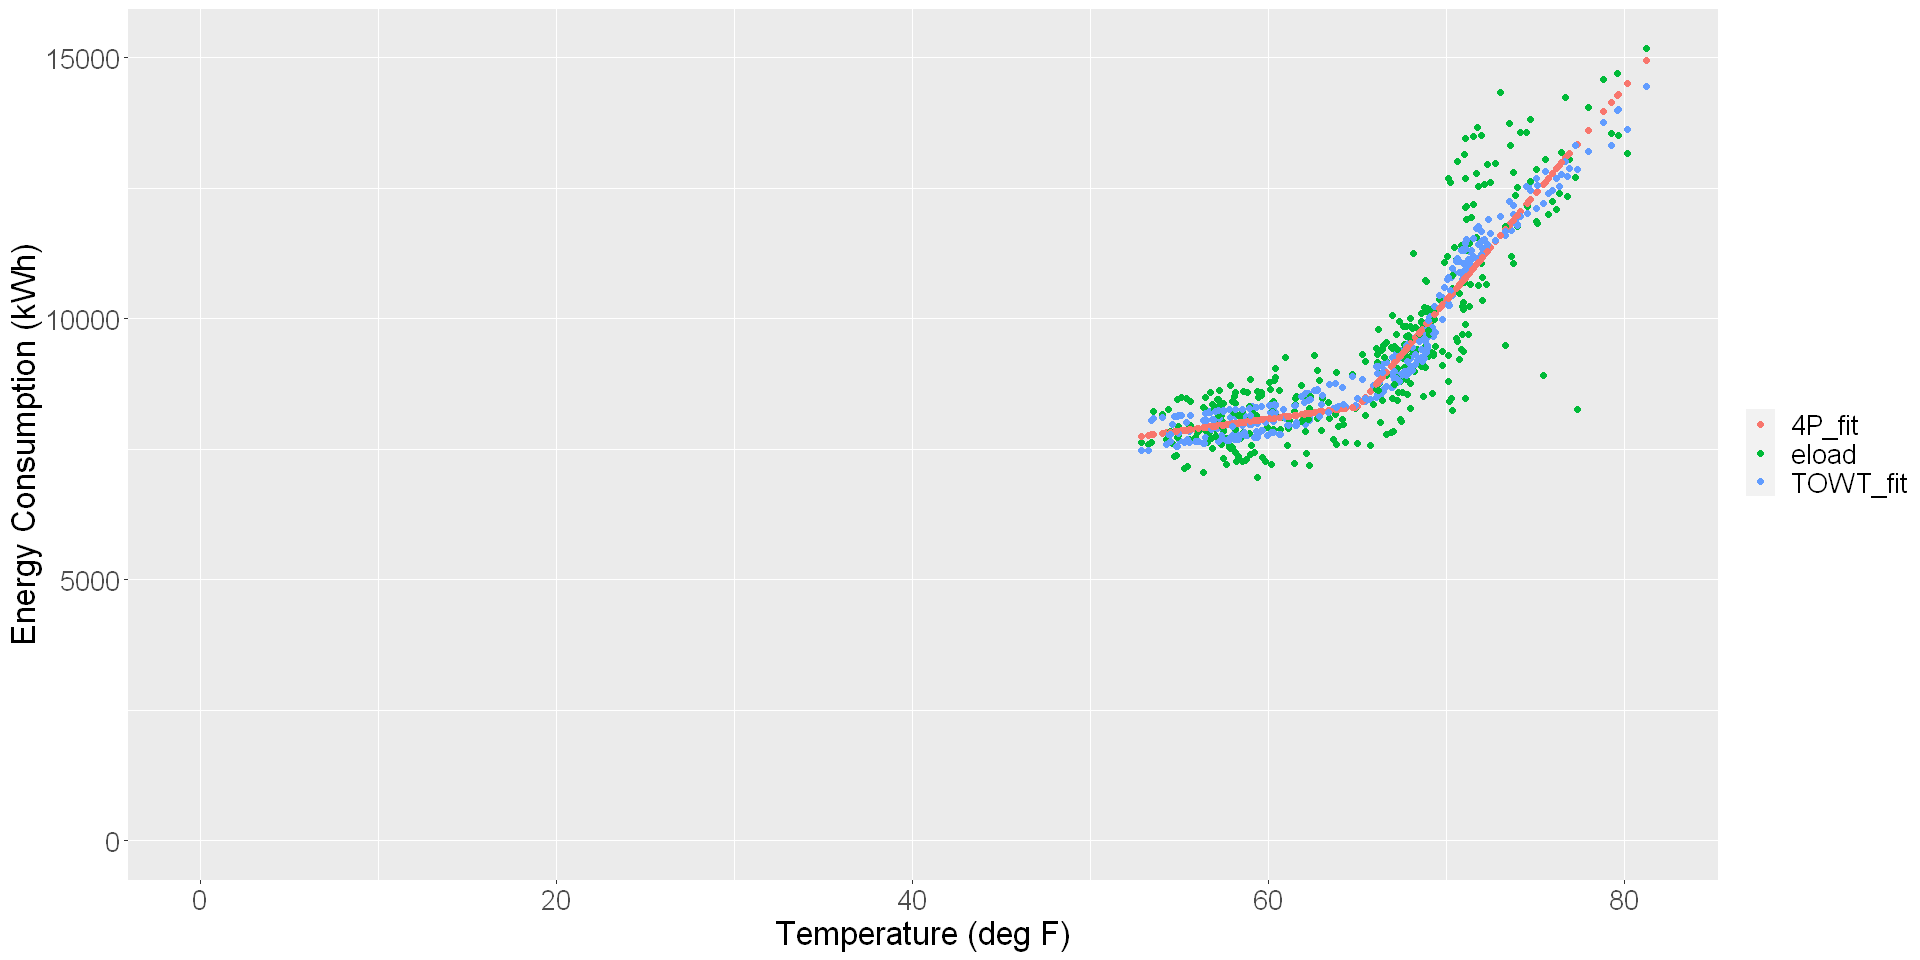

In [9]:
options(repr.plot.width=16, repr.plot.height=8)
generate_scatter_plot(baseline_scatter_df)

In [10]:
## Model Summary Stats 

generate_summary_stats <- function(model1, model2) {
    
    model1_stats <- nmecr::calculate_summary_statistics(model1)
    model1_unc <- nmecr::calculate_savings_and_uncertainty(modeled_object = model1,
                                        model_summary_statistics = model1_stats,
                                        confidence_level = 90)

    model1_metrics <- dplyr::bind_cols(model1_stats, model1_unc)

    model2_stats <- nmecr::calculate_summary_statistics(model2)

    model2_unc <- nmecr::calculate_savings_and_uncertainty(modeled_object = model2,
                                        model_summary_statistics = model2_stats,
                                        confidence_level = 90)

    model2_metrics <- dplyr::bind_cols(model2_stats, model2_unc)

    metrics <- dplyr::bind_rows(model1_metrics, model2_metrics)
    metrics <- metrics[, c(1:5,9:10)]
    names(metrics) <- c("R2", "Adj. R2", "CVRMSE%", "NDBE%", "NMBE%", 
                    "Savings Uncertainty @ 10% Savings", "Savings Fraction for 50% Uncertainty")

    metrics$`NDBE%` <- as.numeric(metrics$`NDBE%`)
    metrics$`NMBE%` <- as.numeric(metrics$`NMBE%`)

    metrics <- metrics %>%
        mutate("Algorithm" = c("4P", "TOWT"))

    metrics <- metrics %>%
        select(c("Algorithm", everything()))

    return(metrics)    
}



In [11]:
generate_summary_stats(four_parameter_model, TOWT_model)

Algorithm,R2,Adj. R2,CVRMSE%,NDBE%,NMBE%,Savings Uncertainty @ 10% Savings,Savings Fraction for 50% Uncertainty
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
4P,0.78,0.78,9.09,-2.407880e-16,-2.427946e-16,0.2759253,0.05518506
TOWT,0.80,0.79,8.67,-2.750334e-14,-2.852489e-14,0.2831296,0.05662593


As per the three thresholds, both models demonstrate feasibility for an NMEC approach. The R2 value is above 0.7, the CV(RMSE) is well below 25%, and NMBE is near zero.

The guidance, however, also notes that "...these (thresholds) do not comprise pass/fail criteria, but rather an analysis that will feed into an interpretation of model suitability".

This statement is very important but is overshadowed by the threshold criteria which serve as heuristics, often used in place of a comprehensive analysis rather than with it. A comprehensive analysis involves looking beyond the minimum 12 months of data and assessing the complete energy use behavior of the site. Limiting our focus to 12 months leaves us oblivious to slow moving overall trends or NREs outside the 12-month period.

One such NRE is the onset of the COVID-19 pandemic. The shelter-in-place restrictions first went into effect in California on March 19th, 2020. The dataset we have here is completely within the shutdown period, and it is hard for me to imagine a facility that has continued to operate similarly during the pandemic as it did prior to the shutdown. 

A well-known and widely trusted way to check for this behavior is to conduct model testing on a dataset different from the one used to develop and train the model. We take another 12 months of data from the same building and test the model’s ability to predict the energy use on this “new” dataset. The only requirement of this methodology is that the building operations and energy use should be similar between the two datasets. In this post, I’ve chosen an additional 12 months of data to test the model. The testing period’s length is context driven and may be lengthened or shortened based on data availability and other factors. The Efficiency Valuation Organization (EVO) uses this methodology  to evaluate the accuracy of M&V tools against the benchmarked public-domain tools. 

In the next section, I apply this process to the candidate models. I have another year of data which I can use to assess the model’s skill in capturing the underlying trend of the site’s energy consumption profile: 

## Expanded Candidate Model Screening (Predictive Accuracy)

The models were built on the dataset: April, 2020 – April, 2021. The NMEC Rulebook requires that the time between the end of the baseline period and the completion of the project implementation stage should not exceed 18 months. To comply with this requirement, I am using the data from April, 2019 – April, 2020 to evaluate the models’ predictive accuracy. The scatter plot below shows the actual energy use in green and the model predictions in red and blue. 

### Predictive Accuracy

In [12]:
energy_temp_df <- nmecr::create_dataframe(eload_data, temp_data, start_date = "2020-03-31",
                                          end_date = "2021-04-01", 
                                          convert_to_data_interval = "Daily")

prediction_energy_temp_df <- nmecr::create_dataframe(eload_data, temp_data, start_date = "2019-03-31",
                                          end_date = "2020-04-01", 
                                          convert_to_data_interval = "Daily")

In [13]:
CP_prediction <- nmecr::calculate_model_predictions(training_data = energy_temp_df,
                                                           prediction_data = prediction_energy_temp_df,
                                                           modeled_object = four_parameter_model)

TOWT_prediction <- nmecr::calculate_model_predictions(training_data = energy_temp_df,
                                                           prediction_data = prediction_energy_temp_df,
                                                           modeled_object = TOWT_model)

all_predictions_df <- CP_prediction %>%
    select(-c("predictions")) %>%
    mutate('4P_predictions' = CP_prediction$predictions) %>%
    mutate('TOWT_predictions' = TOWT_prediction$predictions)

prediction_scatter_df <- tidyr::pivot_longer(all_predictions_df,
                                           cols = c("eload", "4P_predictions", "TOWT_predictions"))

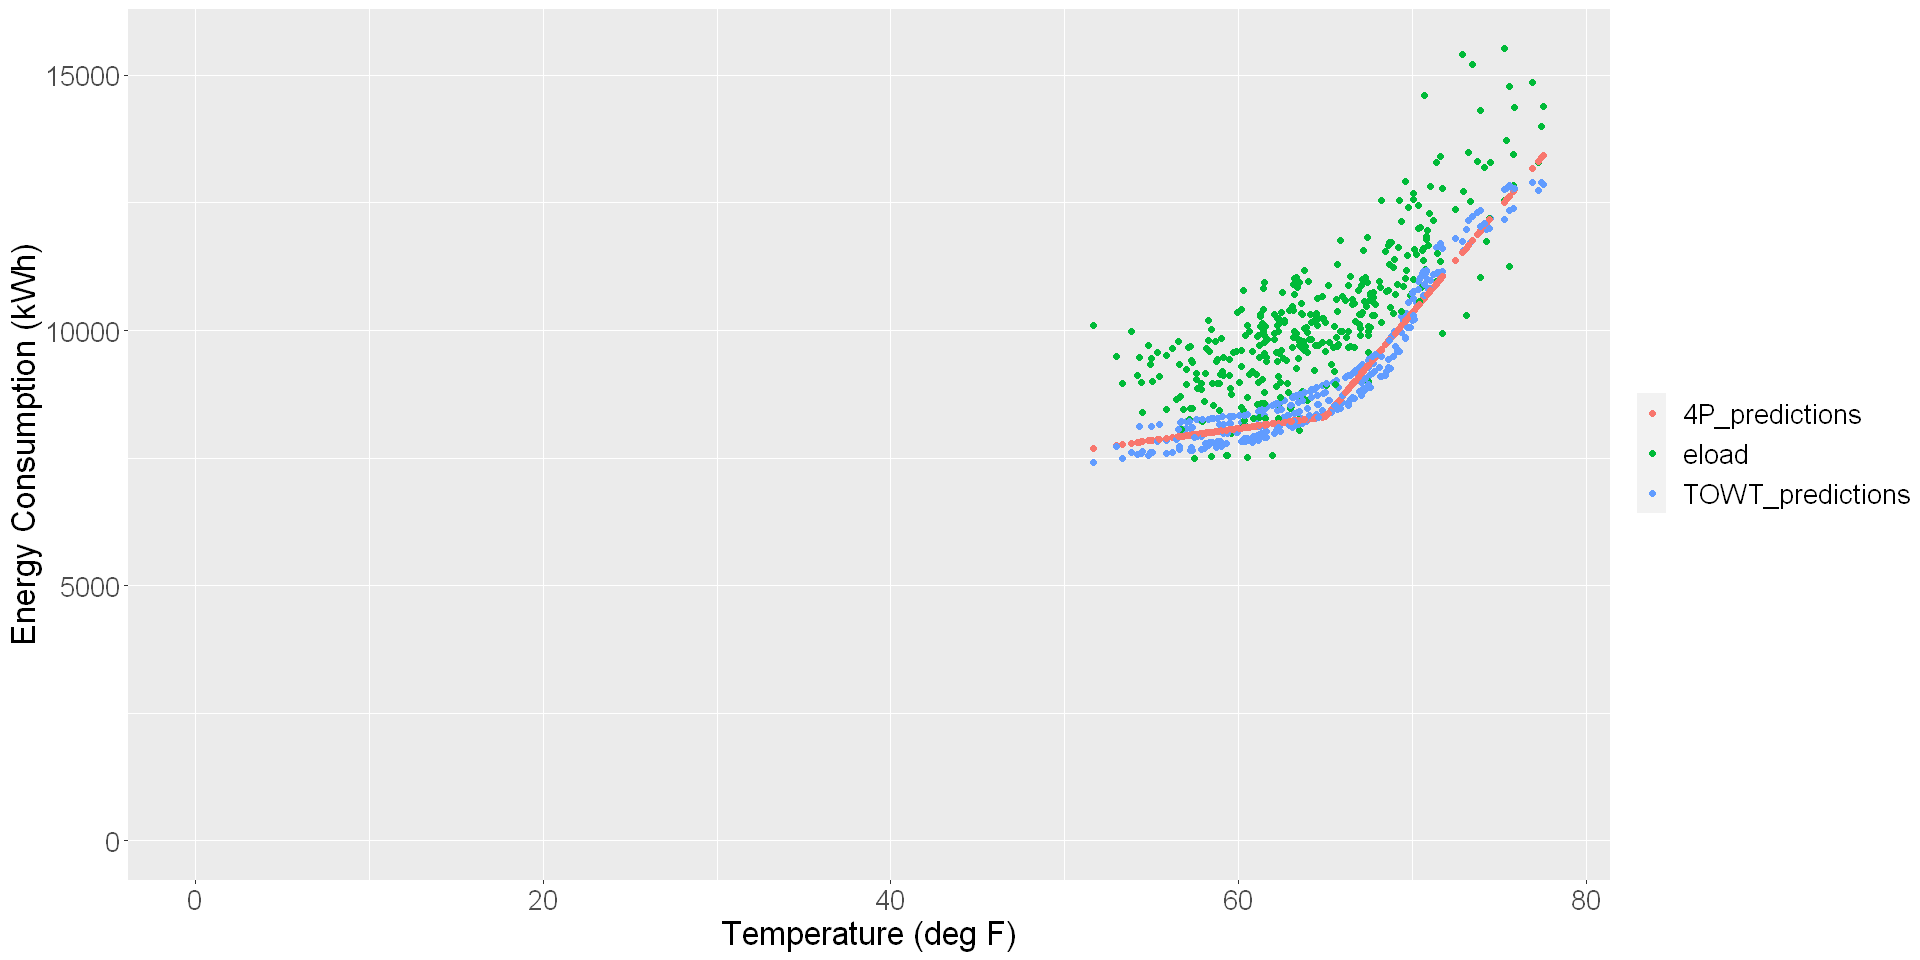

In [14]:
options(repr.plot.width=16, repr.plot.height=8)
generate_scatter_plot(prediction_scatter_df)

Both models’ predictions are much lower than the actual energy use of the building prior to the COVID-19 related shutdowns. This result is expected as most buildings emptied out during the pandemic and consequently, had much lower energy use. As the economy reopens, these buildings will be reoccupied and energy use will go back up. 

If we were to use the models built on the 2020-2021 dataset, the adjusted baseline may be much lower than actual energy use after project implementation, and the project would appear to have negative savings. Narrowly focusing on the three thresholds would, therefore, lead to poor outcomes for pay-for-performance programs and large amounts of losses for the implementers.

In [15]:
calculate_prediction_errors <- function(data) {
    
    CP_prediction_error <- sum(data$eload - data$`4P_predictions`, na.rm = T)/
                            sum(data$eload, na.rm = T)
    TOWT_prediction_error <- sum(data$eload - data$TOWT_predictions, na.rm = T)/
                            sum(data$eload, na.rm = T)
    
    CP_prediction_error <- paste0(round(100*CP_prediction_error, 2), "%")

    TOWT_prediction_error <- paste0(round(100*TOWT_prediction_error, 2), "%")
    
    return(list(CP_prediction_error, TOWT_prediction_error))   
    
}


In [16]:
prediction_errors <- calculate_prediction_errors(all_predictions_df)

message("Prediction Error using the Four Parameter model is ", prediction_errors[1], 
        " while the error for the TOWT model is ", prediction_errors[2])

Prediction Error using the Four Parameter model is 12.62% while the error for the TOWT model is 12.18%



### Additional Independent Variables

After the onset of COVID-19, building occupancy has become as important a predictor as time-of-week and temperature in determining the general trend of energy use profiles. While not all buildings have the luxury of tracking occupancy through key-card swipes, wi-fi connections, or room occupancy, those that do have an easier solution to the problem. 

The prediction errors for the four-parameter model and the TOWT model above was 12.92% and 12.23%, respectively.  After adding in occupancy data to the model, the prediction errors were reduced to 4.25% and 4.07%, respectively. The scatter plot below shows the updated predictions:

In [17]:
occupancy_data <- readRDS("Data/Processed Occupancy Data - multiyear.rds")

In [18]:
energy_temp_df_upd <- nmecr::create_dataframe(eload_data, temp_data, 
                                              additional_independent_variables = occupancy_data,
                                              additional_variable_aggregation = c(median),
                                              start_date = "2020-03-31",
                                              end_date = "2021-04-01", 
                                              convert_to_data_interval = "Daily")

prediction_energy_temp_df_upd <- nmecr::create_dataframe(eload_data, temp_data, 
                                                         additional_independent_variables = occupancy_data,
                                                         additional_variable_aggregation = c(median),
                                                         start_date = "2019-03-31",
                                                         end_date = "2020-04-01", 
                                                         convert_to_data_interval = "Daily")

In [19]:
four_parameter_model_upd <- nmecr::model_with_CP(training_data = energy_temp_df_upd,
                                               model_input_options = nmecr::assign_model_inputs(regression_type = "4P"))

TOWT_model_upd <- nmecr::model_with_TOWT(training_data = energy_temp_df_upd, 
                                     model_input_options = nmecr::assign_model_inputs(regression_type = "TOWT"))

actual_modeled_df_upd <- four_parameter_model_upd$training_data %>%
    select(-c("model_fit")) %>%
    mutate('4P_fit' = four_parameter_model_upd$training_data$model_fit) %>%
    mutate('TOWT_fit' = TOWT_model_upd$training_data$model_fit)

baseline_scatter_df_upd <- tidyr::pivot_longer(actual_modeled_df_upd,
                                           cols = c("eload", "4P_fit", "TOWT_fit"))

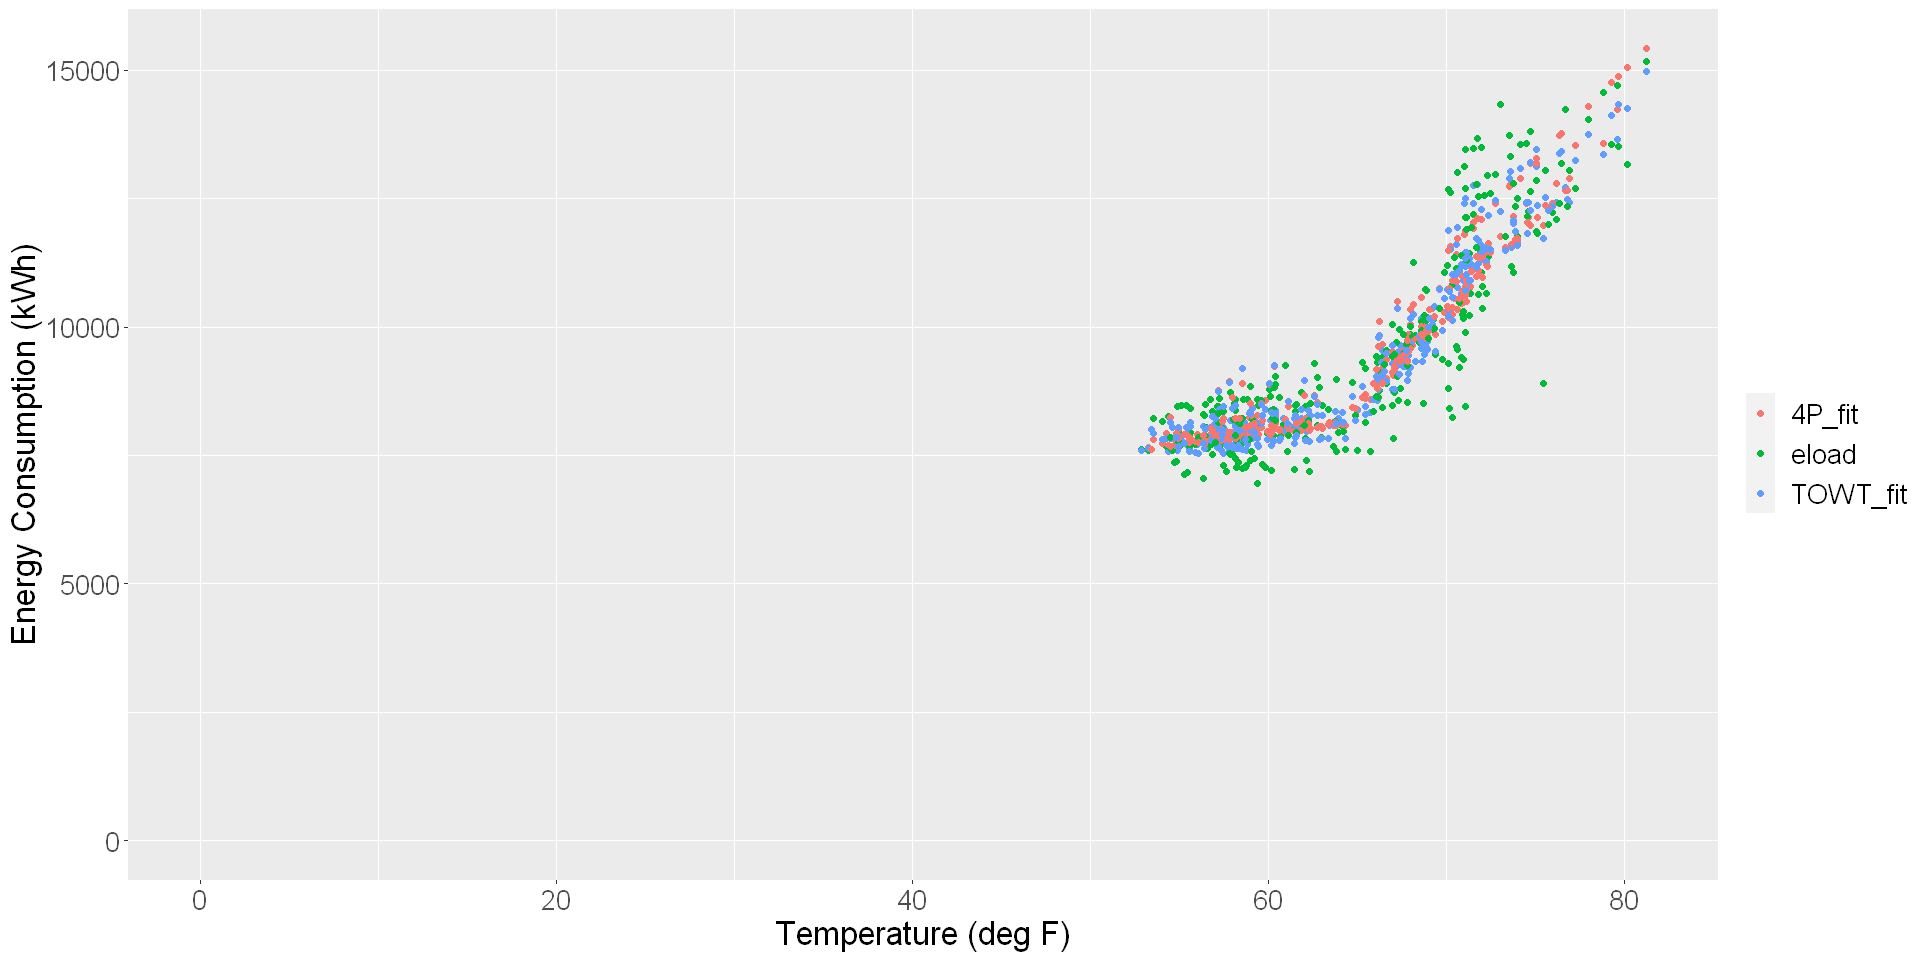

In [20]:
options(repr.plot.width=16, repr.plot.height=8)
generate_scatter_plot(baseline_scatter_df_upd)

In [21]:
CP_prediction_upd <- nmecr::calculate_model_predictions(training_data = energy_temp_df_upd,
                                                           prediction_data = prediction_energy_temp_df_upd,
                                                           modeled_object = four_parameter_model_upd)

TOWT_prediction_upd <- nmecr::calculate_model_predictions(training_data = energy_temp_df_upd,
                                                           prediction_data = prediction_energy_temp_df_upd,
                                                           modeled_object = TOWT_model_upd)

all_predictions_df_upd <- CP_prediction_upd %>%
    select(-c("predictions")) %>%
    mutate('4P_predictions' = CP_prediction_upd$predictions) %>%
    mutate('TOWT_predictions' = TOWT_prediction_upd$predictions)

prediction_scatter_df_upd <- tidyr::pivot_longer(all_predictions_df_upd,
                                           cols = c("eload", "4P_predictions", "TOWT_predictions"))

In [22]:
prediction_errors <- calculate_prediction_errors(all_predictions_df_upd)

message("Prediction Error using the Four Parameter model is ", prediction_errors[1], 
        " while the error for the TOWT model is ", prediction_errors[2])

Prediction Error using the Four Parameter model is 4.25% while the error for the TOWT model is 4.07%



And the updated goodness-of-fit metrics are:

In [23]:
generate_summary_stats(four_parameter_model_upd, TOWT_model_upd)

Algorithm,R2,Adj. R2,CVRMSE%,NDBE%,NMBE%,Savings Uncertainty @ 10% Savings,Savings Fraction for 50% Uncertainty
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
4P,0.86,0.86,7.62,-9.056756e-17,-9.171399e-17,0.1980716,0.03961432
TOWT,0.88,0.87,7.23,-3.915538e-14,-4.094680e-14,0.1976433,0.03952866


Note that the two models have almost identical goodness-of-fit metrics. The occupancy variable provides information to the changepoint model that the TOWT tries to glean from the data internally. In this scenario, I would go with the simpler algorithm to develop the baseline model for this site’s M&V Plan.

## Summary

Testing a model's ability to predict data that it has not seen before is analogous to sitting for an exam. You can get the top score on an assessment if you are free to look through the answer key. Similarly, a model can perform very well on the dataset it is trained on and present low goodness-of-fit metrics. This is especially true for the advanced machine-learning algorithms that are built to minimize the model error. If left unchecked, many of these advanced algorithms begin to model the noise in the data and can present a false sense of high accuracy to the analyst. The technical term for this behavior is over-fitting. 

Your knowledge of the subject matter is truly tested when you give the exam and don't have the answers readily available. And similarly, a model's ability to produce reliable predictions, which can be used to correctly quantify project savings, is truly assessed using a new dataset that is different from the one the model was trained on, but is similar enough such that the data profiles are consistent with the training dataset. After all, you want the exam to cover the material that you studied for.

A robust model is one that is built using all influential data streams and is able to produce reliable predictions on an 'unseen' dataset. Limiting its characteristics to the three goodness-of-fit metrics will corner us into an uncomfortable spot with a false sense of security and high exposure to financial as well as environmental risk.